Loading dataset...
Preprocessing (Denoising)...
Building feature matrix...
Applying ADASYN resampling...
Training XGBoost model...
Evaluating model...

--- Classification Report ---
              precision    recall  f1-score   support

         ARR       0.90      0.93      0.92      1020
         CHF       0.78      0.71      0.74       306
         NSR       0.96      0.96      0.96       357

    accuracy                           0.90      1683
   macro avg       0.88      0.87      0.87      1683
weighted avg       0.89      0.90      0.89      1683



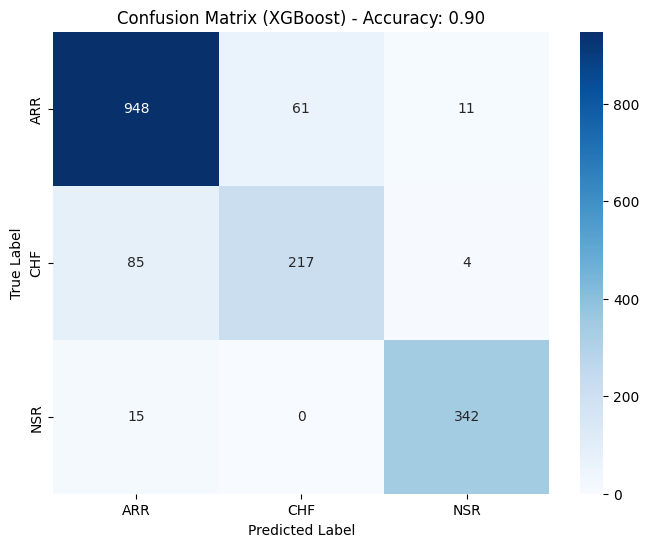

In [ ]:
import numpy as np
import pandas as pd
import pywt
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
from imblearn.over_sampling import ADASYN

# ==========================================
# 1. CONFIGURATION
# ==========================================
FS = 128
SEGMENT_SEC = 10 
SEG_LEN = FS * SEGMENT_SEC
WAVELET_NAME = 'sym5' 
LEVEL = 5

# ==========================================
# 2. DATA LOADING
# ==========================================
print("Loading dataset...")
try:
    X_raw = pd.read_csv("data/ECGData.csv", header=None).values
    y_raw = pd.read_csv("data/ECGDataLabel.csv", header=None)[0]
except FileNotFoundError:
    print("Dataset not found.")

le = LabelEncoder()
y_all = le.fit_transform(y_raw)

# ==========================================
# 3. PREPROCESSING & FEATURE EXTRACTION
# ==========================================
def wavelet_denoising(signal, wavelet='sym5', level=2):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745
    uthresh = sigma * np.sqrt(2 * np.log(len(signal)))
    coeffs[1:] = [pywt.threshold(c, value=uthresh, mode='soft') for c in coeffs[1:]]
    return pywt.waverec(coeffs, wavelet)

print("Preprocessing (Denoising)...")
X_denoised = np.array([wavelet_denoising(x, wavelet=WAVELET_NAME, level=2) for x in X_raw])

def calculate_entropy(signal):
    prob = np.abs(signal)**2
    prob = prob / (np.sum(prob) + 1e-10)
    return -np.sum(prob * np.log2(prob + 1e-10))

def calculate_zcr(signal):
    return ((signal[:-1] * signal[1:]) < 0).sum() / len(signal)

def extract_features(signal, wavelet='sym5', level=5):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    features = []
    total_energy = np.sum([np.sum(c**2) for c in coeffs]) + 1e-10
    
    for c in coeffs:
        c = np.asarray(c)
        energy_c = np.sum(c**2)
        features.extend([
            np.mean(c),             
            np.std(c),
            np.max(c), np.min(c),
            np.sqrt(np.mean(c**2)),  
            skew(c), kurtosis(c),            
            calculate_entropy(c),
            energy_c / total_energy, 
            calculate_zcr(c)
        ])
    return features

# ==========================================
# 4. SEGMENTATION & DATASET CREATION
# ==========================================
indices = np.arange(len(X_denoised))
train_idx, test_idx = train_test_split(indices, test_size=0.2, stratify=y_all, random_state=42)

def create_dataset(indices, X_data, y_data):
    X_out, y_out = [], []
    for i in indices:
        signal = X_data[i]
        label = y_data[i]
        num_segments = len(signal) // SEG_LEN
        for j in range(num_segments):
            start = j * SEG_LEN
            end = start + SEG_LEN
            segment = signal[start:end]
            feats = extract_features(segment, wavelet=WAVELET_NAME, level=LEVEL)
            X_out.append(feats)
            y_out.append(label)
    return np.array(X_out), np.array(y_out)

print("Building feature matrix...")
X_train, y_train = create_dataset(train_idx, X_denoised, y_all)
X_test, y_test = create_dataset(test_idx, X_denoised, y_all)

# ==========================================
# 5. SCALING & RESAMPLING (ADASYN)
# ==========================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Applying ADASYN resampling...")
adasyn = ADASYN(random_state=42)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train_scaled, y_train)

# ==========================================
# 6. MODEL TRAINING (XGBOOST)
# ==========================================
print("Training XGBoost model...")
model = XGBClassifier(
    n_estimators=500,        
    learning_rate=0.05,      
    max_depth=10,            
    subsample=0.8,           
    colsample_bytree=0.8,    
    objective='multi:softprob',
    random_state=42,
    n_jobs=-1
)

model.fit(X_train_resampled, y_train_resampled)

# ==========================================
# 7. EVALUATION
# ==========================================
print("Evaluating model...")
y_pred = model.predict(X_test_scaled)

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred, target_names=target_names))

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names)
plt.title(f"Confusion Matrix (XGBoost) - Accuracy: {model.score(X_test_scaled, y_test):.2f}")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()